# 🐡 The sharp points of Rockpool 🐚

In [2]:
# - Rockpool imports
from rockpool import TSContinuous

# - General imports and configuration
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## 🦀 How to use sampled time series data (in)correctly in Rockpool
Time series data loaded from elsewhere probably comes in a clocked raster format. You can easily use this data in Rockpool, but there are a couple of tricky points to watch out for.

### Wrong: how to generate a time base for clocked data

In [3]:
T = 1000
dt = 1e-3
data = np.random.rand(T)
t_start = 23.6
time_base = np.arange(t_start, t_start + len(data) * dt, dt)

In [4]:
time_base = np.arange(T) * dt + t_start

### Wrong: how to define a time series from clocked data

Say we have a 20-second sample, sampled on a 100ms clock. Let's convert this into a continuous time series:

In [5]:
dt = 100e-3
T = round(20 / dt)
data = np.random.rand(T)
time_base = np.arange(len(data)) * dt

ts = TSContinuous(time_base, data)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 19.900000000000002. Samples: 200. Channels: 1

In [6]:
ts = TSContinuous(time_base, data, t_stop = 20.)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.0. Samples: 200. Channels: 1

In [7]:
ts = TSContinuous.from_clocked(data, dt=dt)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.000000000000004. Samples: 200. Channels: 1

## 🎣 How to generate a time series
A related problem can occur if you define a time series at a low temporal resolution, and then resample it at higher resolution. For example, imagine you want to generate a random noise time series:

In [8]:
time_low_res = np.arange(0, 1, 0.25)
ts = TSContinuous(time_low_res, np.random.rand(len(time_low_res)))
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 0.75. Samples: 4. Channels: 1

Seems pretty reasonable. But notice again that the duration of the series is maybe not what we were expecting... If we try to sample this time series at a higher temporal resolution, we get some unexpected results:

In [9]:
time_high_res = np.arange(0, 1, 0.1)
print(ts(time_high_res)) # <-- contains NANs

[[0.88831047]
 [0.88831047]
 [0.88831047]
 [0.71632229]
 [0.71632229]
 [0.3609541 ]
 [0.3609541 ]
 [0.3609541 ]
 [       nan]
 [       nan]]


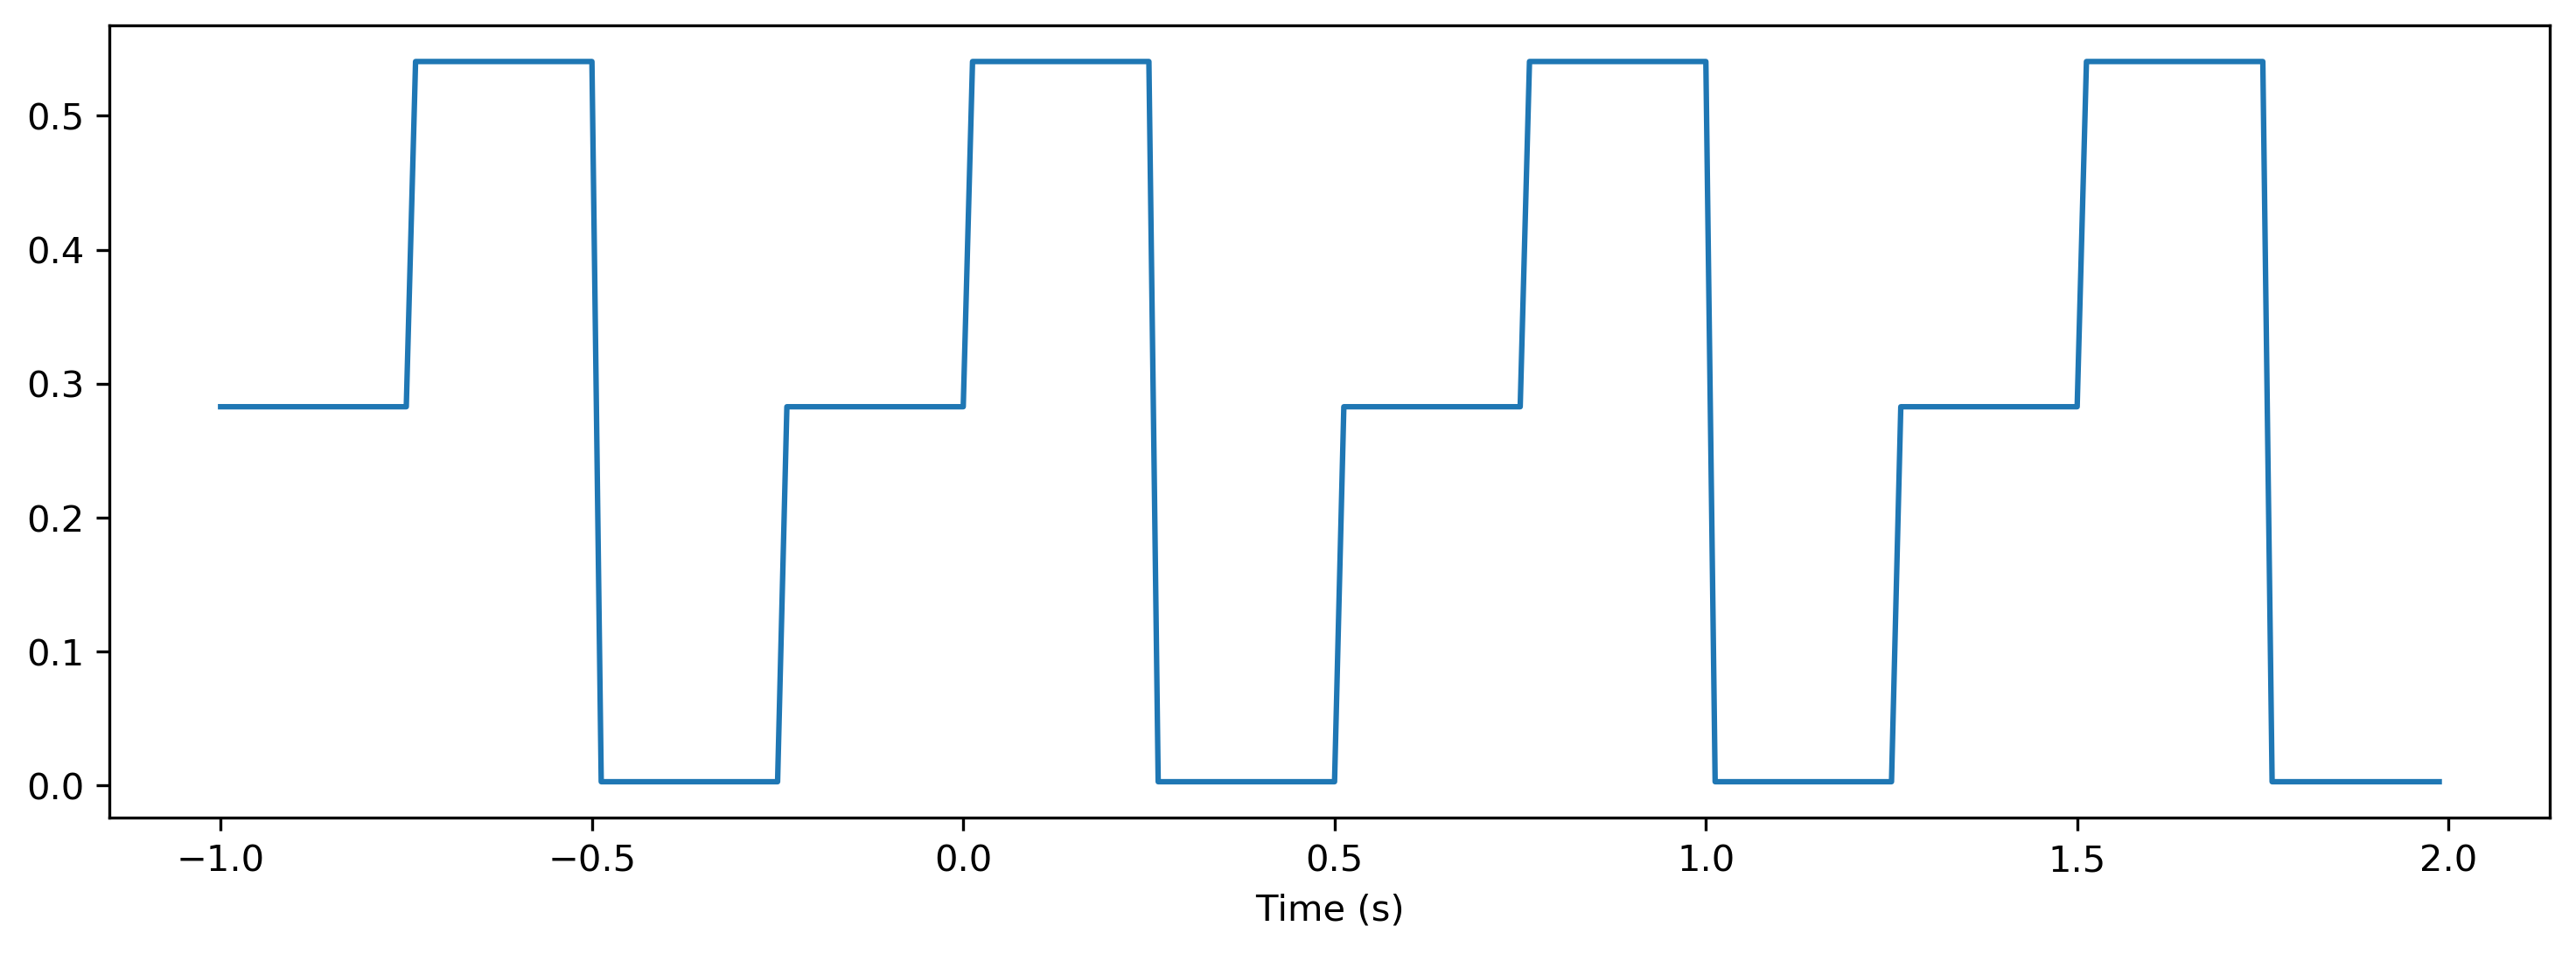

In [10]:
ts = TSContinuous(time_low_res,
                  np.random.rand(len(time_low_res)),
                  periodic = True,
                 )
ts.plot(np.arange(-1, 2, .0125));

In [11]:
dt = 0.25
T = int(1 // dt)

ts = TSContinuous.from_clocked(np.random.rand(T), dt=dt)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 4. Channels: 1

## 🐚 Defining extents for `TSEvent` time series data

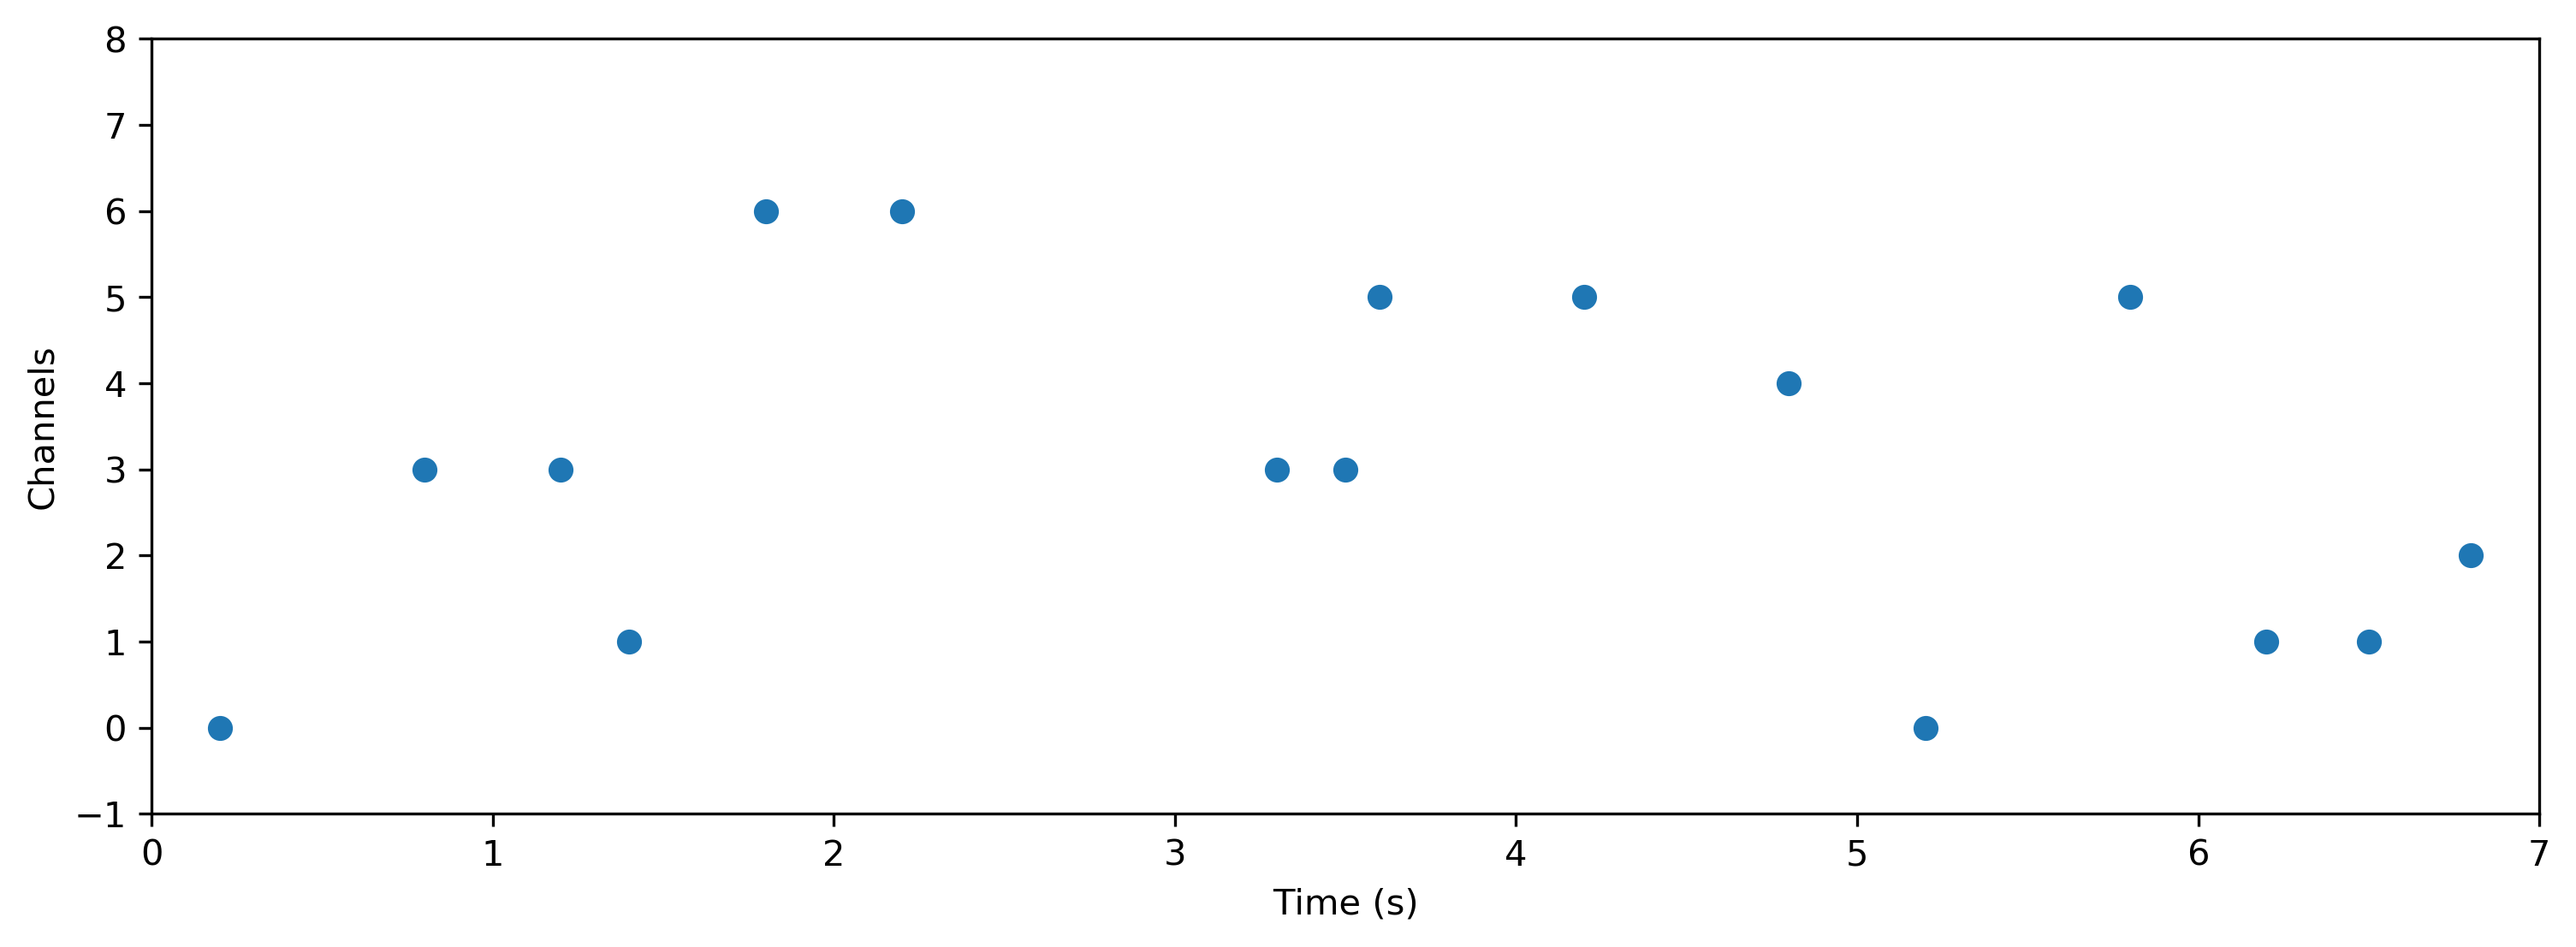

In [12]:
from rockpool import TSEvent
from matplotlib import pyplot as plt

times = [.2, .8, 1.2, 1.4, 1.8, 2.2, 3.3, 3.5, 3.6, 4.2, 4.8, 5.2, 5.8, 6.2, 6.5, 6.8]
channels = [0, 3, 3, 1, 6, 6, 3, 3, 5, 5, 4, 0, 5, 1, 1, 2]
ts = TSEvent(times, channels, t_start = 0., t_stop = 7.)
ts.plot();

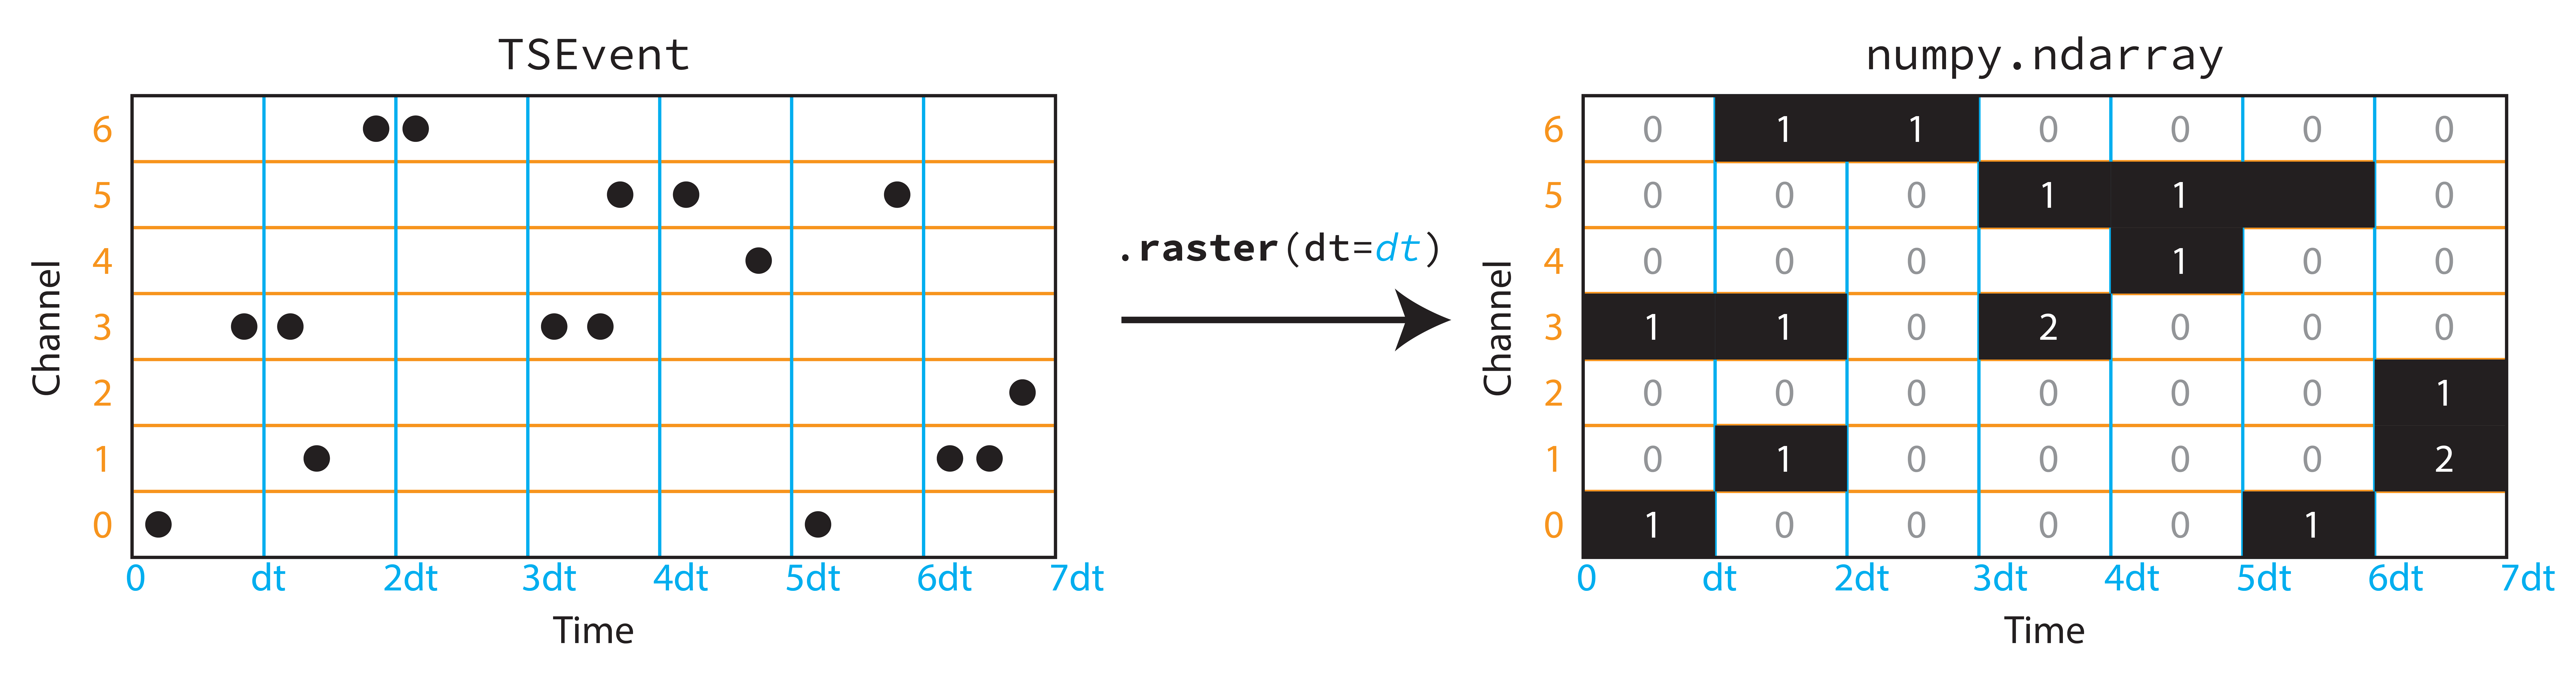

In [13]:
from IPython.display import Image
Image("TSEvent_to_raster.png")

```python
def raster(
    dt: float,
    t_start: float=None,
    t_stop: float=None,
    num_timesteps: int=None,
    channels: numpy.ndarray=None,
    add_events: bool=False,
    include_t_stop: bool=False,
) -> numpy.ndarray:
```

In [14]:
tsBad = TSEvent(times, channels, name = 'No extents 🤢🤬')
print(tsBad)

tsGood = TSEvent(times, channels, t_start = 0., t_stop = 7., name = 'With extents 😇🥰')
print(tsGood)

non-periodic `TSEvent` object `No extents 🤢🤬` from t=0.2 to 6.8. Channels: 7. Events: 16
non-periodic `TSEvent` object `With extents 😇🥰` from t=0.0 to 7.0. Channels: 7. Events: 16


## 🐡 `TimeSeries` and `Layer`s share an explicit global time base

In [15]:
# - Imports
from rockpool.layers import FFRateEuler
from rockpool import TSContinuous

# - Define a layer with a single rate neuron
lyr = FFRateEuler([1], dt = 1e-3)
print('lyr:', lyr)

# - Define a time series
data = np.sin(np.arange(0, 10, dt) / 4 * (2*np.pi))
ts_input = TSContinuous.from_clocked(data, dt = .1)
print('ts_input:', ts_input)

lyr: FFRateEuler object: "unnamed" [1 TSContinuous in -> 1 internal -> 1 TSContinuous out]
ts_input: non-periodic TSContinuous object `unnamed` from t=0.0 to 4.0. Samples: 40. Channels: 1


Now we evolve `lyr` using `ts_input`, and look at the result.

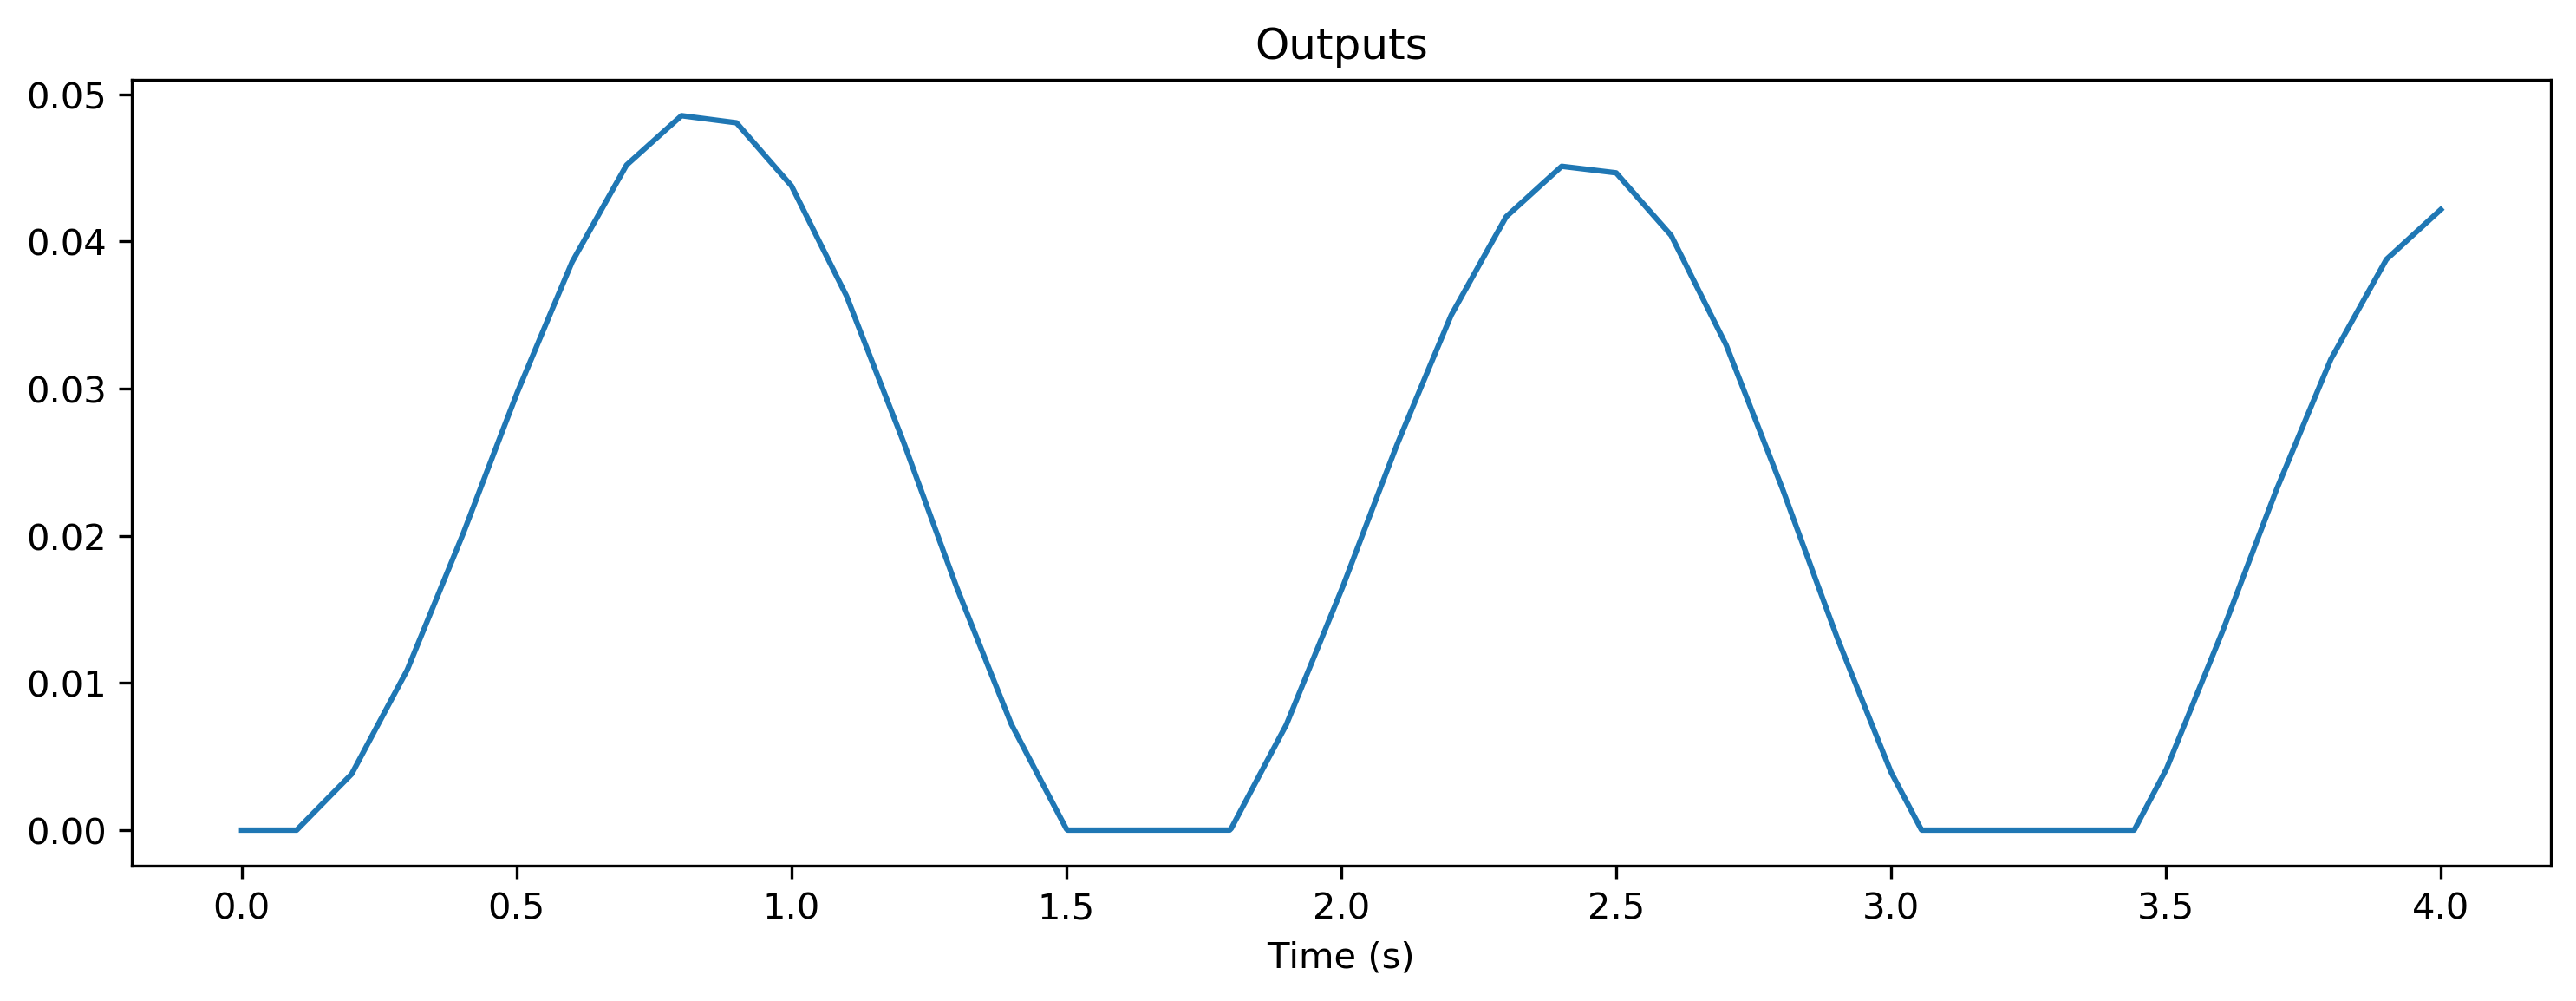

In [16]:
lyr.evolve(ts_input).plot();

But if we try to evolve `lyr` again in the same way, we recieve an error.

In [17]:
lyr.evolve(ts_input)

AssertionError: Layer `unnamed`: Cannot determine an appropriate evolution duration. `ts_input` finishes before the current evolution time.

In [18]:
print('lyr.t:', lyr.t)
print('ts_input:', ts_input)

lyr.t: 4.0
ts_input: non-periodic TSContinuous object `unnamed` from t=0.0 to 4.0. Samples: 40. Channels: 1


In [19]:
ts_input(10.1)

array([[nan]])

WARNING    /Users/dylanaictx/aiCTX Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/layers/layer.py:224: UserWarning: Layer `unnamed`: Evolution period (t = 4.0 to 14.0) is not fully contained in input signal (t = 0.0 to 4.0). You may need to use a `periodic` time series.
  + " You may need to use a `periodic` time series."
 [py.warnings]


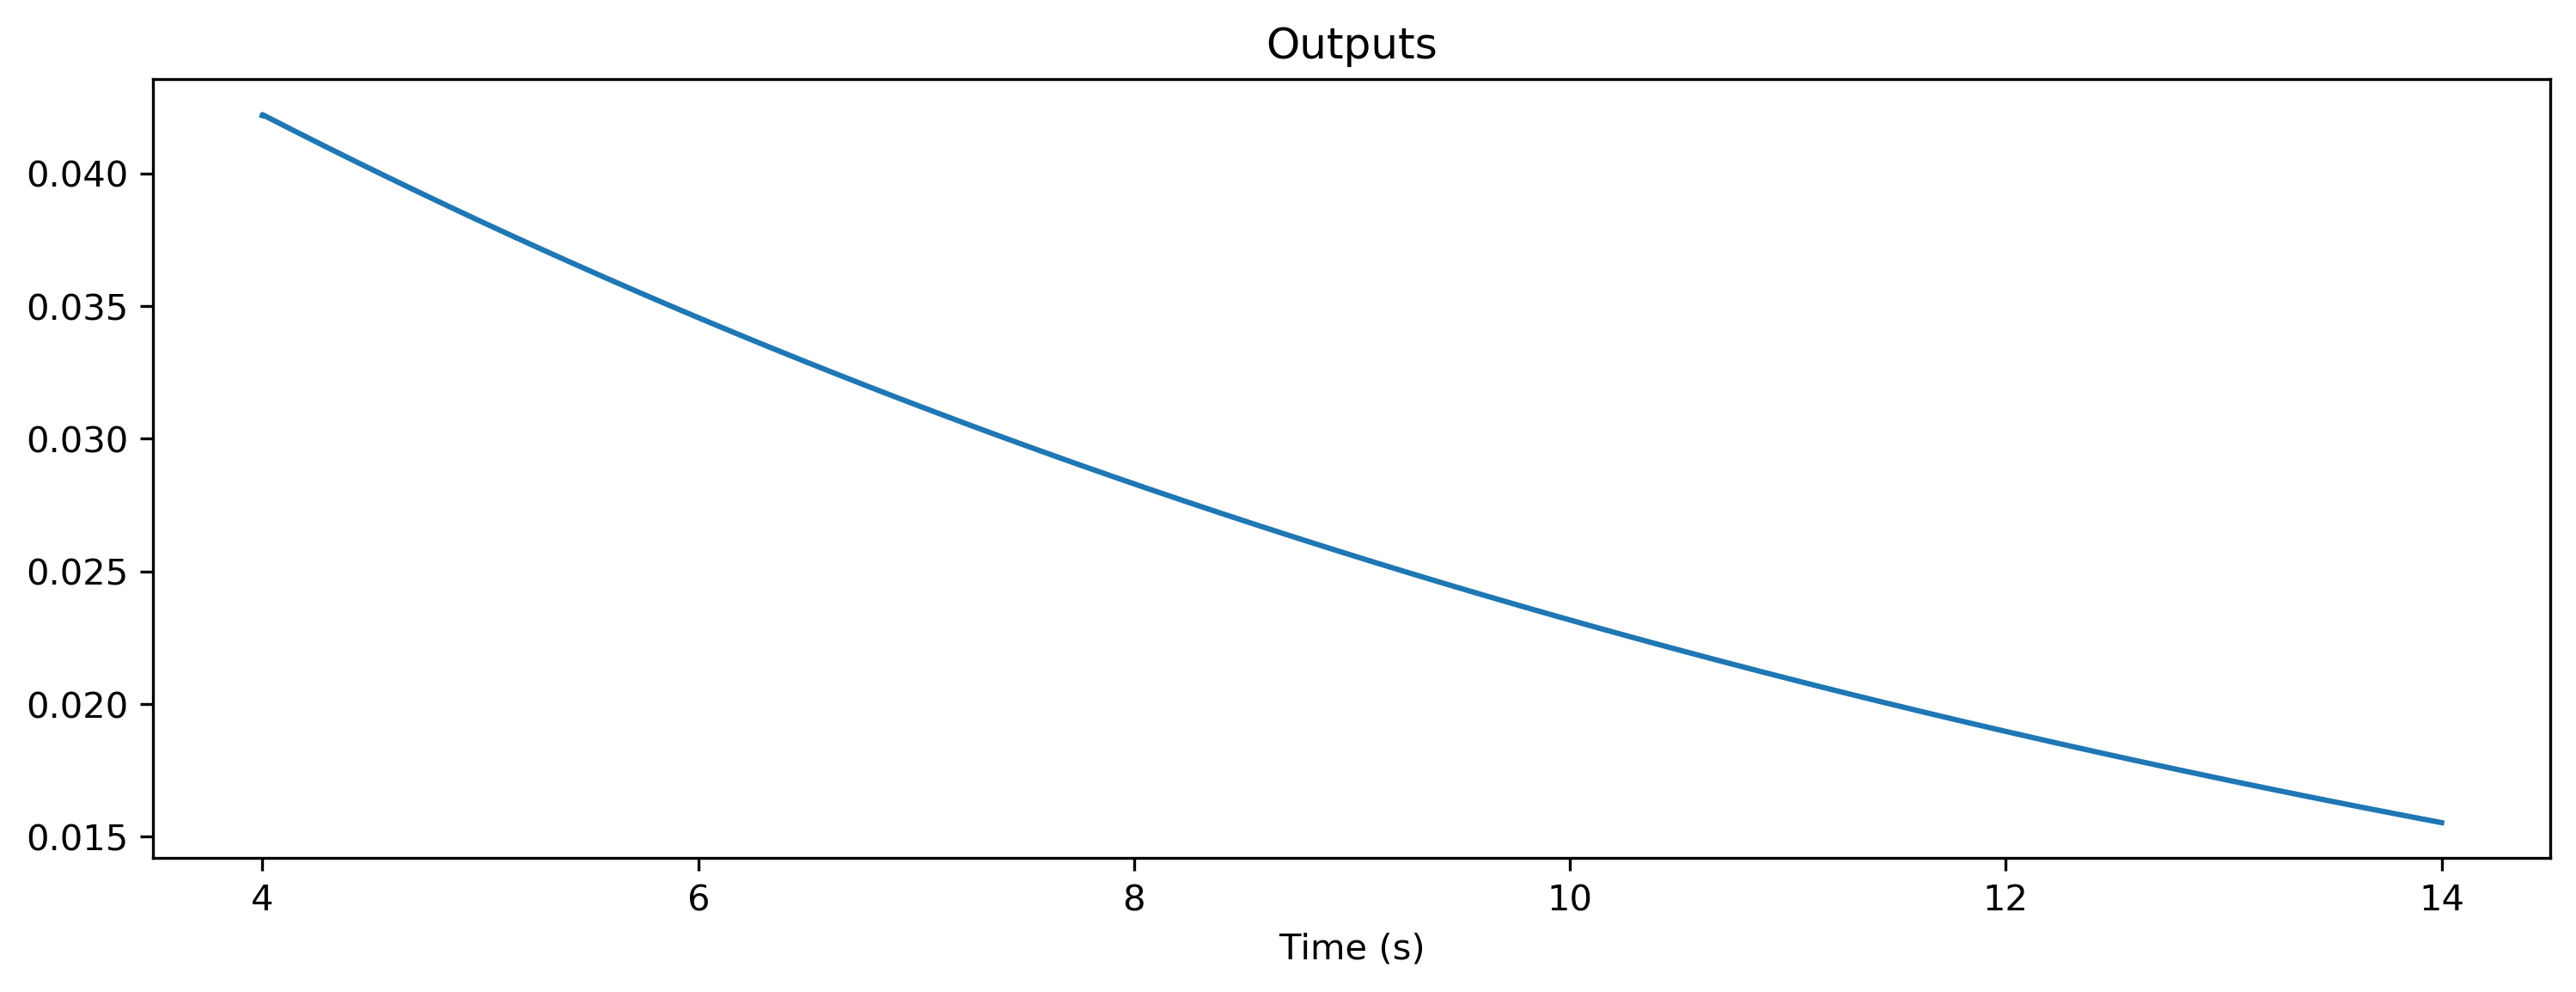

In [20]:
lyr.evolve(ts_input, duration = 10).plot();

In [21]:
ts_input = TSContinuous.from_clocked(data, dt = .1, t_start = lyr.t)
print('ts_input:', ts_input)

ts_input: non-periodic TSContinuous object `unnamed` from t=14.0 to 18.0. Samples: 40. Channels: 1


In [22]:
# - Using `.start_at()`
lyr.evolve(ts_input.start_at(lyr.t))

# - Using `.delay()`
lyr.evolve(ts_input.delay(lyr.t - ts_input.t_start))

non-periodic TSContinuous object `Outputs` from t=18.0 to 22.0. Samples: 4001. Channels: 1

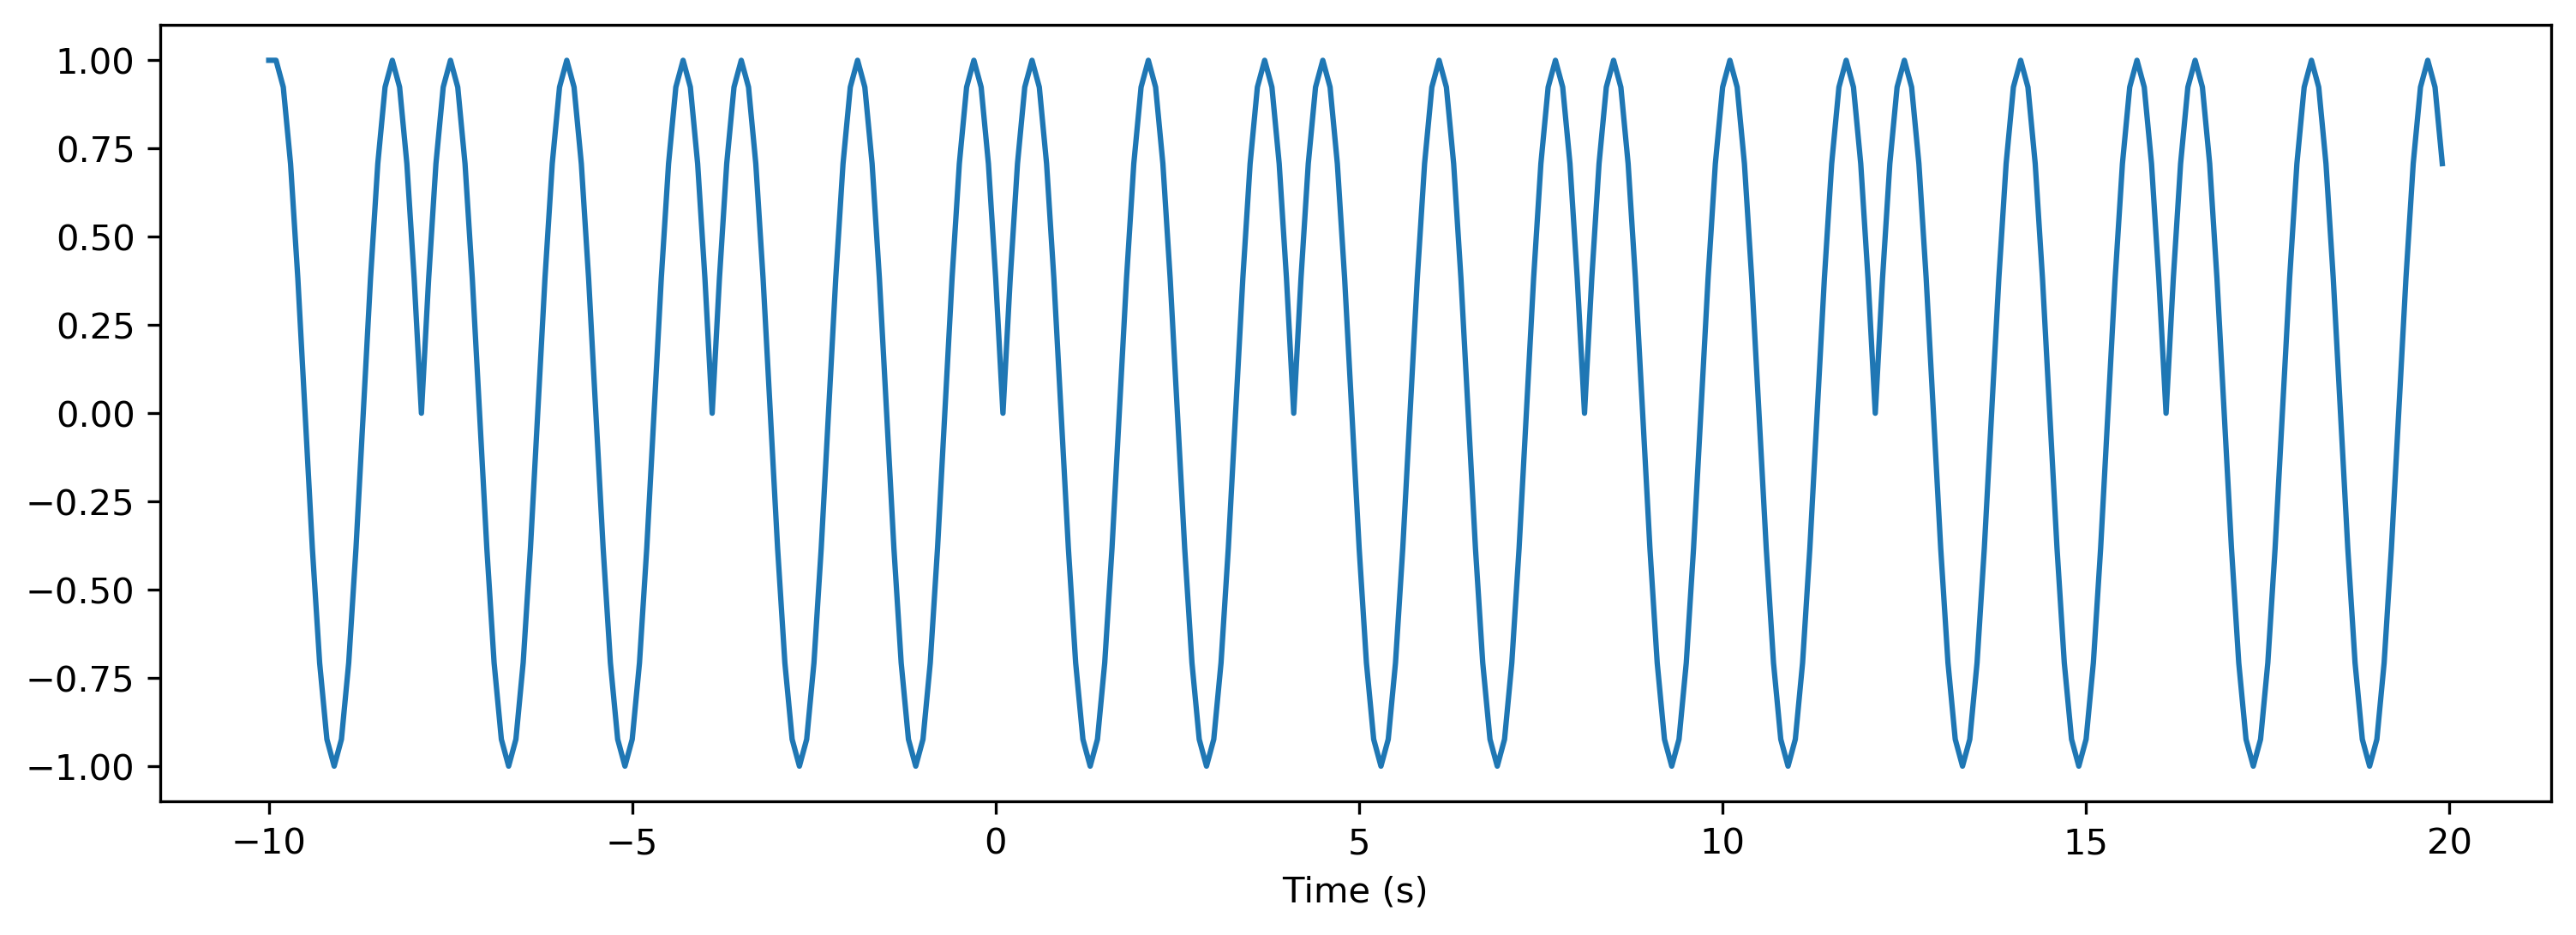

In [23]:
ts_input = TSContinuous.from_clocked(data, dt = .1, periodic = True)
ts_input.plot(np.arange(-10, 20, .1));

In [24]:
lyr.evolve(ts_input)
lyr.evolve(ts_input)

non-periodic TSContinuous object `Outputs` from t=26.0 to 30.0. Samples: 4001. Channels: 1

## 🦀 `Layer`s in Rockpool are dynamical systems, and don't get reset implicitly